In [37]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## Testing what input dimensionalities PyTorch CNN filters need

In [38]:
vec = np.ones((100, 100))
tens = torch.tensor(vec, dtype=torch.float32)


In [39]:
tens.shape

torch.Size([100, 100])

In [40]:
tens = tens.unsqueeze(0)
tens = tens.view(100, 1, 100)

In [41]:
m = nn.Conv1d(1, 1, 3, stride=1)
input = tens
output = m(input)

In [42]:
tens

tensor([[[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.]]])

In [43]:
output

tensor([[[1.0760, 1.0760, 1.0760,  ..., 1.0760, 1.0760, 1.0760]],

        [[1.0760, 1.0760, 1.0760,  ..., 1.0760, 1.0760, 1.0760]],

        [[1.0760, 1.0760, 1.0760,  ..., 1.0760, 1.0760, 1.0760]],

        ...,

        [[1.0760, 1.0760, 1.0760,  ..., 1.0760, 1.0760, 1.0760]],

        [[1.0760, 1.0760, 1.0760,  ..., 1.0760, 1.0760, 1.0760]],

        [[1.0760, 1.0760, 1.0760,  ..., 1.0760, 1.0760, 1.0760]]],
       grad_fn=<ConvolutionBackward0>)

## Examining output from Dense and U-Net networks trained on 1D Poisson Eqn. data

In [44]:
from PyT_tinymodels import (OneD_UNet, TinyModel, smoother)

load models and state dictionaries:

In [45]:
device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )

UNet = OneD_UNet(1,1).to(device)
UNet.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/unet_poisson.pth"))

Dense = TinyModel().to(device)
Dense.load_state_dict(torch.load("/Users/GUSTO/environments/firedrake/src/gusto/learning/poisson.pth"))

Smoother = smoother().to(device)

sm_kernel = torch.tensor([0.05, 0.075, 0.1, 0.175, 0.2, 0.175, 0.1, 0.075, 0.05], dtype=torch.float32)
smoother = lambda input: F.conv1d(input, sm_kernel.view(1, 1, -1), padding=4)

examine performance on standard input of RHS of ones:

In [46]:
vec = np.ones((100, 100))
tens = torch.tensor(vec, dtype=torch.float32)

with torch.no_grad():
    out = Dense(tens)
    out = out.unsqueeze(1)
    #print(out.shape)
    out = smoother(out)
    out = smoother(out)
    
Dense_out = torch.Tensor.numpy(out)

tens = tens.unsqueeze(1)
UNet.eval()
with torch.no_grad():
    out = UNet(tens)
UNet_out = torch.Tensor.numpy(out)

The performance of the U-Net is appaling. The dense network is somewhat okay after adding some smoothing with a fairly broad filter.

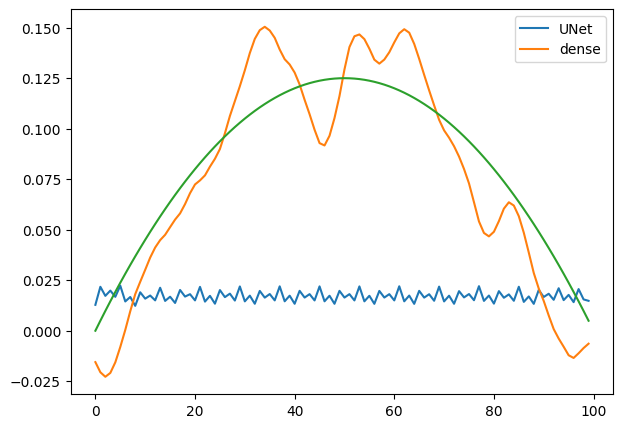

In [47]:
xs = np.arange(100, step=1)
test = (- xs **2 + 100*xs)*0.00005
plt.plot(UNet_out[2][0], label = 'UNet')
plt.plot(Dense_out[2][0], label = 'dense')
plt.plot(test)
plt.legend()

#### Here is why random RHS vectors for training do not work well 
It's just noise and there are no patterns to learn. Additionally, soln becomes tiny compared to RHS.

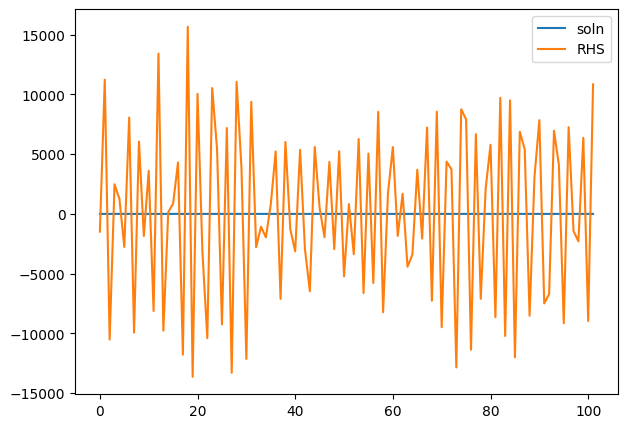

In [48]:
matrix = (2*np.eye(102) - np.eye(102, k=-1) - np.eye(102, k=1))*100**2
#matrix[-1][0] = -1
#matrix[0][-1] = -1
vec_out = np.random.rand(1000, 102)
vec_in = np.dot(vec_out, matrix)
plt.plot(vec_out[0], label = 'soln')
plt.plot(vec_in[0], label = 'RHS')
plt.legend()

## Generating smooth training data
Simple superposition of sines

In [49]:
xs = np.arange(102, step=1)
a = 0.1 * np.random.randn(1000)
b = 0.05 * np.random.randn(1000)
c = 0.03 * np.random.randn(1000)
d = 0.03 * np.random.randn(1000)
vec_out = np.zeros((1000, 102))
for i in np.arange(1000):
    vec_out[i] = (a[i] * np.sin(np.pi/100 * xs) + b[i] * np.sin(np.pi/100 * 2 * xs) + 
               c[i] * np.sin(np.pi/100 * 3 * xs) + d[i] * np.sin(np.pi/100 * 4 * xs))
    
vec_in = np.dot(vec_out, matrix)

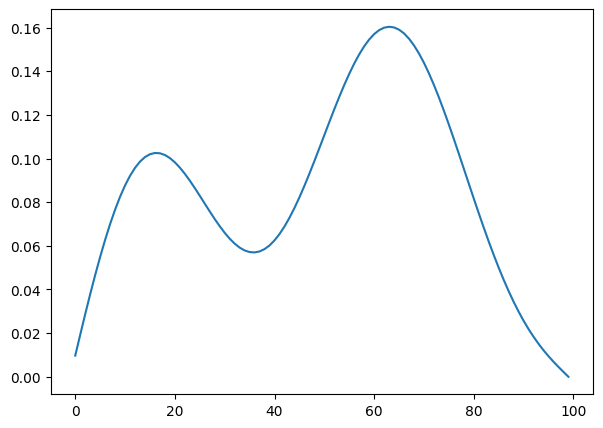

In [57]:
plt.plot(vec_out[1])

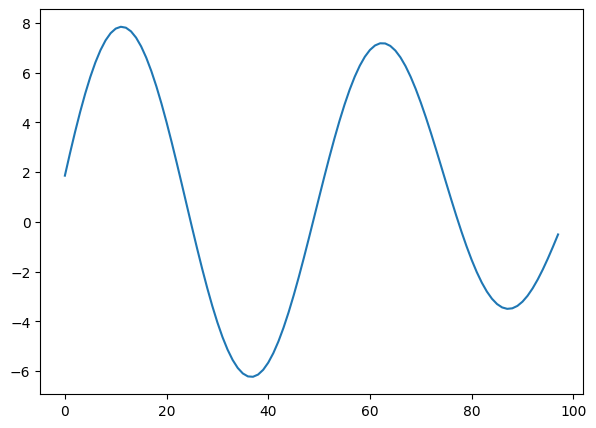

In [59]:
plt.plot(vec_in[1][1:-1])

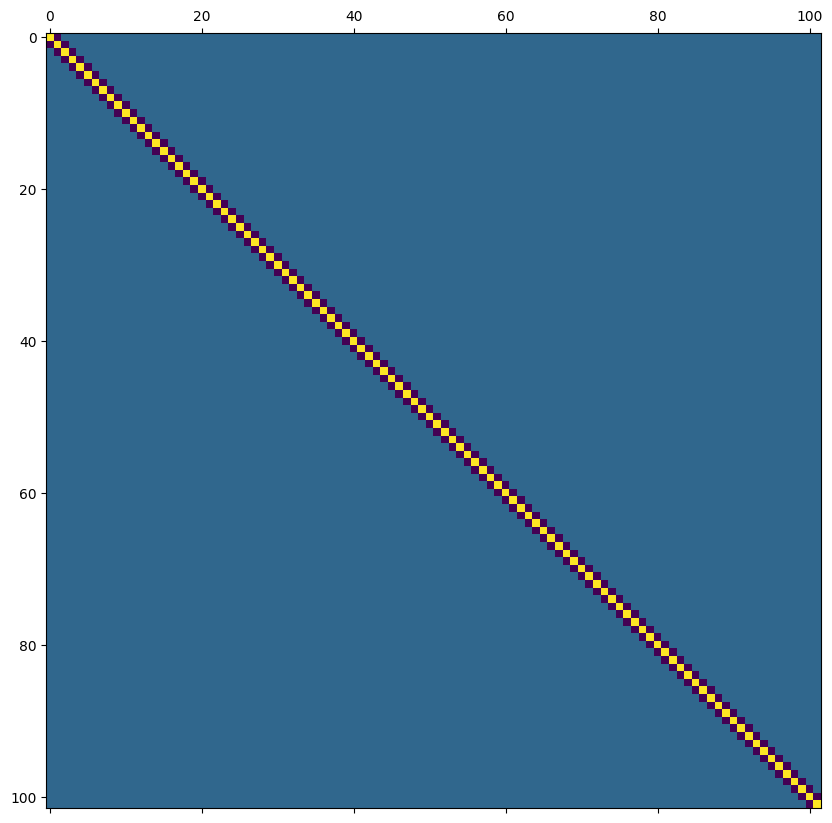

In [52]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.matshow(matrix)
plt.rcParams["figure.figsize"] = [7, 5]

The below is just to check the solution vector obtained from a constant RHS of ones

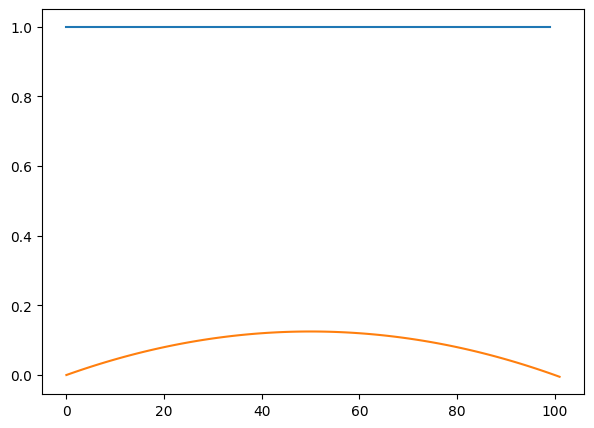

In [53]:
test = (- xs **2 + 100*xs)*0.00005
plt.plot(np.dot(test, matrix)[1:-1])
plt.plot(test)

Need to cut off the sides of the vectors because somehow they like shooting off to large values - improperly specified BCs in the matrix?

In [54]:
vec_in = vec_in[:, 1:-1]
vec_out = vec_out[:, 1:-1]

In [55]:
vec_in.shape

(1000, 100)

Let's just check model performance on signal drawn from the distribution that generated its training data (i.e. sine wave superposition):

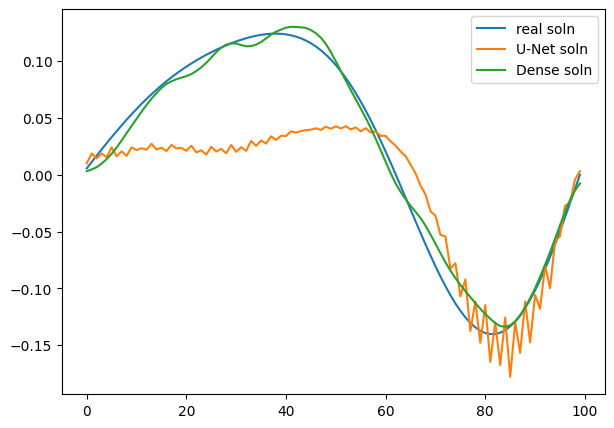

In [61]:
tens = torch.tensor(vec_in[:100, :], dtype=torch.float32)
tens = tens.unsqueeze(1)
UNet.eval()
with torch.no_grad():
    out = UNet(tens)
UNet_out = torch.Tensor.numpy(out)

tens = torch.tensor(vec_in, dtype=torch.float32)
with torch.no_grad():
    out = Dense(tens)
    out = out.unsqueeze(1)
    out = smoother(out)
    out = smoother(out)
Dense_out = torch.Tensor.numpy(out)


fig, ax = plt.subplots()
s = 3
ax.plot(vec_out[s], label = 'real soln')
ax.plot(UNet_out[s][0], label = 'U-Net soln')
ax.plot(Dense_out[s][0], label = 'Dense soln')

ax.legend()

## Why is GCR still not converging despite the dense model's outputs looking reasonable-ish?

To try and find out if this is now just a maths issue or if there is something wrong with my code, I output vectors from the solve at the following points:

- In MLCtx.mult(), we write the input vectors to ``ml_invecs.txt`` and the output vectors to ``ml_outvecs.txt``
- In Laplace1D.mult(), we again write the input vectors to ``lapl_invecs.txt``and the output vectors to ``lapl_outvecs.txt``.

This outputting only happens if we pass the ``-info`` flag when executing.

From Ackmann et al. (2020), we expect GCR to work like this (where the system to be solved is $\mathcal{L} \Phi = R$):

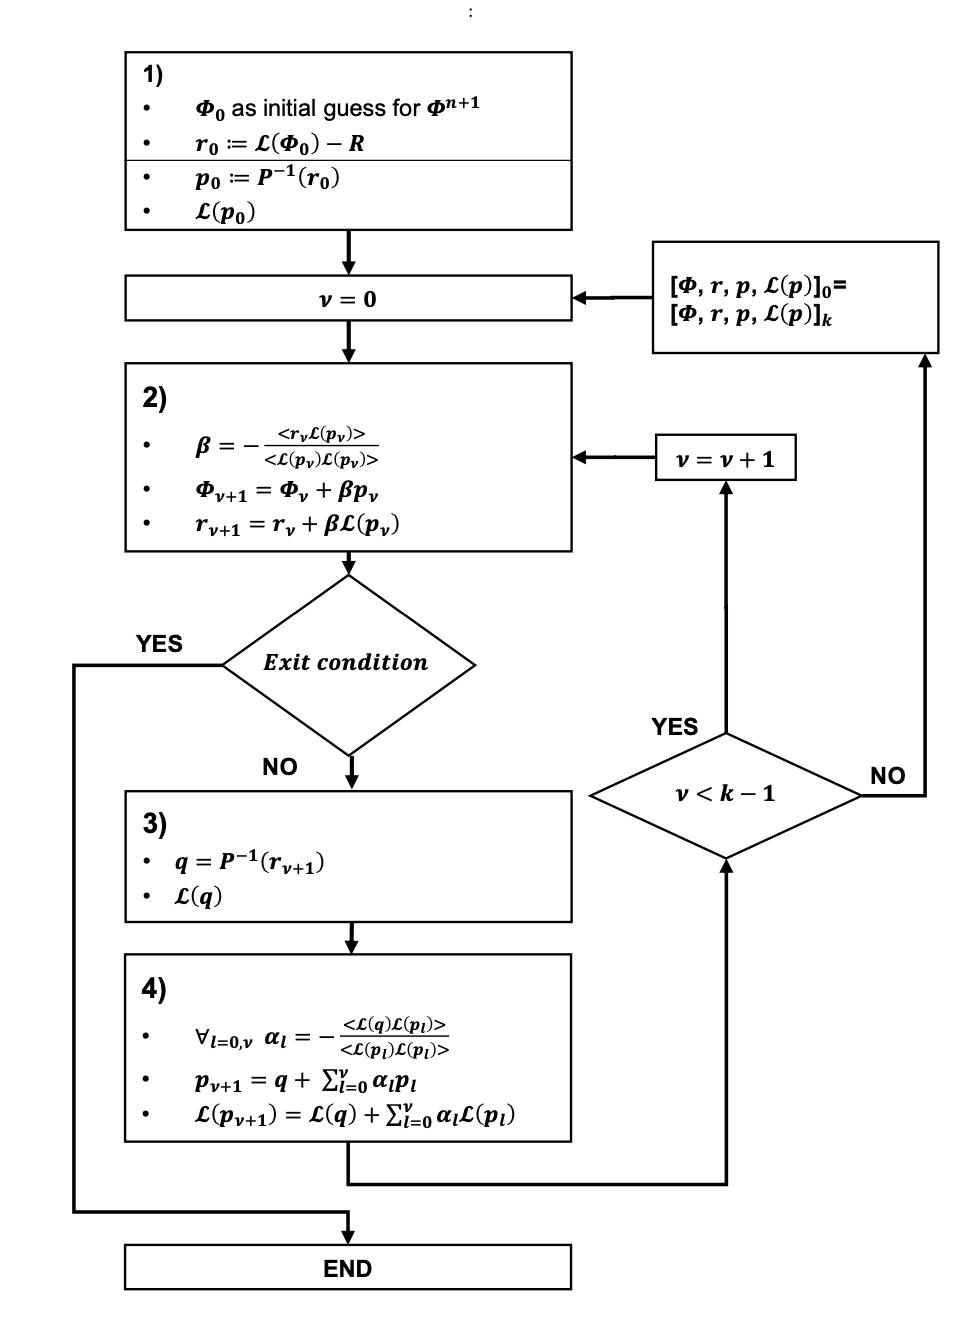


Wo we expect the first input to the laplacian to be some first guess (maybe just zeros) and the first input to the ML model the result of that guess minus the RHS. For reference, the RHS used for this run is just a vector of ones. 

In [63]:
datadir = '/Users/GUSTO/data/debug/'
ml_invecs = np.loadtxt(datadir + 'ml_invecs.txt', delimiter=',')
ml_outvecs = np.loadtxt(datadir + 'ml_outvecs.txt', delimiter=',')
lapl_invecs = np.loadtxt(datadir + 'lapl_invecs.txt', delimiter=',')
lapl_outvecs = np.loadtxt(datadir + 'lapl_outvecs.txt', delimiter=',')

As a sanity check, let's see if they're all the same length. We expect that at each iteration, the ML model does one inference on the residual, the output of which is then passed to the Laplacian, and that result should be used several times at that iterate (does not need to be recomputed), so we expect them all to be the same length.

In [73]:
print('num. of vectors in ML input file: ', len(ml_invecs))
print('num. of vectors in ML output file: ', len(ml_outvecs))
print('num. of vectors in Laplacian input file: ', len(lapl_invecs))
print('num. of vectors in Laplacian input file: ', len(lapl_outvecs))

num. of vectors in ML input file:  10000
num. of vectors in ML output file:  10000
num. of vectors in Laplacian input file:  10002
num. of vectors in Laplacian input file:  10002


This seems like the Laplacian is maybe applied additionally once at the beginning and once at the end of the run. Strange, but we won't worry too much for now...

The first input to the laplacian is indeed a vector of zeros, which naturally means the first output is as well:

In [71]:
lapl_invecs[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

...so we'd expect the first input to the ML model to be a vector of -1s:

In [72]:
ml_invecs[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Hm! They're ones. Maybe this implementation of GCR works a little differently from Ackmann et al.'s?

Anyway! Is at least the output of the ML model in subsequent iterations equal to the input of the Laplacian?

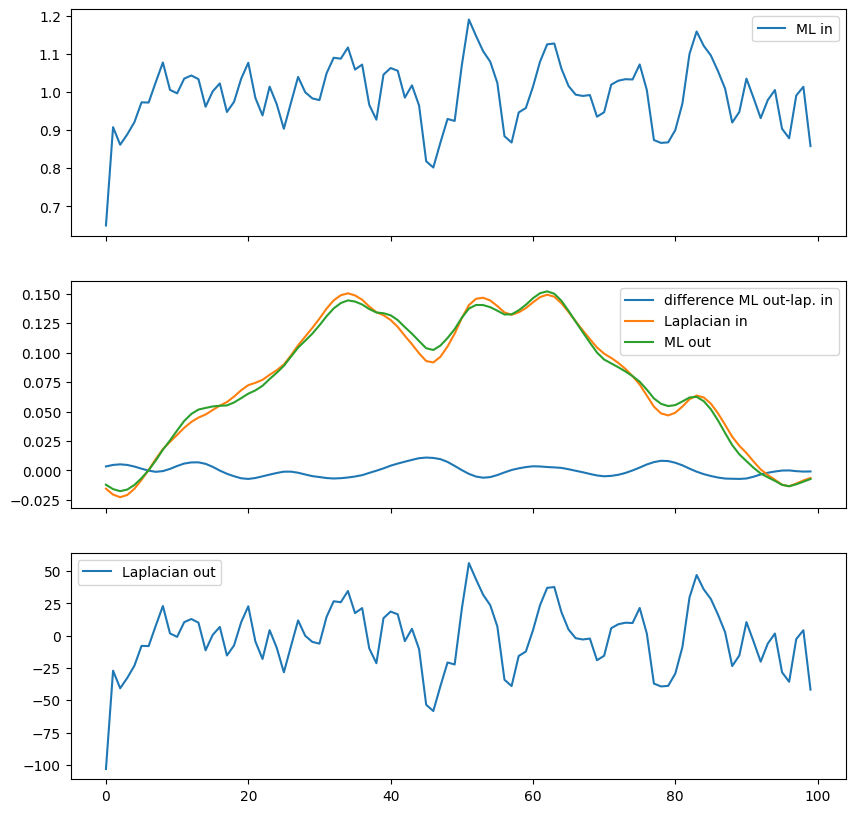

In [101]:
it = 1
fig, ax = plt.subplots(3,1, sharex = True, figsize = (10, 10))
ax[1].plot(ml_outvecs[it] - lapl_invecs[it], label = 'difference ML out-lap. in')
ax[1].plot(lapl_invecs[it], label = 'Laplacian in')
ax[1].plot(ml_outvecs[it], label = 'ML out')
ax[1].legend()

ax[0].plot(ml_invecs[it], label = 'ML in')
ax[2].plot(lapl_outvecs[it], label = 'Laplacian out')
ax[0].legend()
ax[2].legend()

No! Although the difference is always quite small. Another striking feature is that the iterations seem quite similar to one another.

(N.B. the figure is set such that it mimics the flow of the solver in any single iteration: ML input -> ML output -> Laplacian input -> Laplacian output; the input to the next iteration is then a linear combination of the previous input and the previous laplacian output scaled by a factor $\beta$).